In [1]:
import json

# Load data from the JSON file
with open('550w.json', 'r') as f:
    data = json.load(f)

# Extract main bounding box
main_box_data = data['boundingBox']
main_box = [
    main_box_data['sw']['latitude'],
    main_box_data['sw']['longitude'],
    main_box_data['ne']['latitude'],
    main_box_data['ne']['longitude']
]

# Extract solar panel data
solarPotential_data = data['solarPotential']
solar_panels_data = solarPotential_data.get('solarPanels', [])
solarPotential_structure = {key: type(value).__name__ for key, value in solarPotential_data.items()}

# Print the number of solar panels
#print(f"Number of solar panels: {len(solar_panels_data)}")

# Extract roof segment statistics
roofSegmentStats_data = solarPotential_data.get('roofSegmentStats', [])

bounding_box_data = data['boundingBox']

# Extract heights of each sample and store in a list
sample_heights = []
for i, segment in enumerate(roofSegmentStats_data):
    height = segment.get('planeHeightAtCenterMeters', None)
    if height is not None:
        sample_heights.append(height)

# Extract sample boxes
sample_boxes = []
for sample in roofSegmentStats_data:
    box = sample.get('boundingBox', {})
    sw = box.get('sw', {})
    ne = box.get('ne', {})
    sample_box = [
        sw.get('latitude', None),
        sw.get('longitude', None),
        ne.get('latitude', None),
        ne.get('longitude', None)
    ]
    sample_boxes.append(sample_box)

# Dimensions of a single solar panel in inches
panel_width = 60
panel_height = 70



In [2]:
from scipy.optimize import minimize_scalar
import math
import pandas as pd
import folium
import logging

logging.basicConfig(level=logging.INFO)

# Function to rotate a point
def rotate_point(x, y, angle_degrees, cx, cy):
    angle_radians = math.radians(angle_degrees)
    dx = x - cx
    dy = y - cy
    rotated_dx = dx * math.cos(angle_radians) - dy * math.sin(angle_radians)
    rotated_dy = dx * math.sin(angle_radians) + dy * math.cos(angle_radians)
    return cx + rotated_dx, cy + rotated_dy

# Function to calculate rotated bounding box area
def rotated_area(angle_degrees, original_area, aspect_ratio):
    angle_radians = math.radians(float(angle_degrees))
    return original_area * (math.cos(angle_radians) + aspect_ratio * math.sin(angle_radians))

# Function to find the optimal rotation angle
def find_common_optimal_rotation_angle(data):
    def objective(angle_degrees):
        total_diff = 0
        for segment in data['solarPotential']['roofSegmentStats']:
            sw = segment['boundingBox']['sw']
            ne = segment['boundingBox']['ne']
            original_area = abs((ne['latitude'] - sw['latitude']) * (ne['longitude'] - sw['longitude']))
            aspect_ratio = abs((ne['longitude'] - sw['longitude']) / (ne['latitude'] - sw['latitude']))
            target_area = segment['stats']['groundAreaMeters2']
            diff = abs(rotated_area(angle_degrees, original_area, aspect_ratio) - target_area)
            
            # Weighted by the original area
            weighted_diff = diff * original_area
            
            total_diff += weighted_diff
        return total_diff
    
    result = minimize_scalar(objective, bounds=(0, 90), method='bounded', options={'maxiter': 100})
    return result.x

# Find the common optimal angle for all segments
common_optimal_angle = find_common_optimal_rotation_angle(data)
logging.info(f"Common optimal angle for all segments: {common_optimal_angle}")

# Initialize the folium map centered around a sample location
first_sample = data['solarPotential']['roofSegmentStats'][0]
initial_ne = first_sample['boundingBox']['ne']
initial_location = [initial_ne['latitude'], initial_ne['longitude']]
m = folium.Map(location=initial_location, zoom_start=15)

# Loop through each segment in 'roofSegmentStats'
for i, segment in enumerate(data['solarPotential']['roofSegmentStats']):
    center = segment['center']
    center_lat, center_long = center['latitude'], center['longitude']
    
    sw = segment['boundingBox']['sw']
    ne = segment['boundingBox']['ne']
    width = abs(ne['longitude'] - sw['longitude'])
    height = abs(ne['latitude'] - sw['latitude'])
    
    # Rotate the corners around the center
    rotated_sw = rotate_point(sw['latitude'], sw['longitude'], common_optimal_angle, center_lat, center_long)
    rotated_ne = rotate_point(ne['latitude'], ne['longitude'], common_optimal_angle, center_lat, center_long)
    rotated_se = rotate_point(ne['latitude'], sw['longitude'], common_optimal_angle, center_lat, center_long)
    rotated_nw = rotate_point(sw['latitude'], ne['longitude'], common_optimal_angle, center_lat, center_long)
    
    # Draw the rotated bounding box as a polygon on the map
    folium.Polygon([rotated_sw, rotated_se, rotated_ne, rotated_nw, rotated_sw], color='red').add_to(m)
    #logging.info(f"Added bounding box with corners: {rotated_sw, rotated_se, rotated_ne, rotated_nw}")

# Show the map
m


INFO:root:Common optimal angle for all segments: 62.11802161326996


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sympy import symbols, solve, Eq, sqrt
# Given points A(x1, y1) and B(x2, y2) and area A
x1, y1 = 0, 0
A = (x1, y1)
x2, y2 = 4, 3
B = (x2, y2)
Area = 10

# Calculate distance d between A and B
d = sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Calculate radius r of the circumcircle
r = d / 2

# Calculate the center O of the circumcircle
x_center = (x1 + x2) / 2
y_center = (y1 + y2) / 2

# Calculate the other dimension (either width or height) using the area A
other_dimension = Area / d

# Use the equation of the circle to find point C(x3, y3)
x3, y3 = symbols('x3 y3')

# Equation of the circle
eq1 = Eq((x3 - x_center)**2 + (y3 - y_center)**2, r**2)

# Equation representing the distance from A to C equal to the other dimension
eq2 = Eq(sqrt((x3 - x1)**2 + (y3 - y1)**2), other_dimension)

# Equation for 90-degree angles using dot product of vectors AB and AC
eq3 = Eq((x3 - x1) * (x2 - x3) + (y3 - y1) * (y2 - y3), 0)

# Solve the equations to find point C(x3, y3)
solution_with_dot_product = solve((eq1, eq2, eq3), (x3, y3))
C1,C2 = solution_with_dot_product
final_c= [C1,C2]
print (C1,C2)

# Function to calculate D1 and D2 algebraically without using the solve function
def calculate_D_algebraic(x_center, y_center, C):
    x3, y3 = C
    x4 = 2 * x_center - x3
    y4 = 2 * y_center - y3
    return x4, y4

# Initialize list to store the corresponding D points using the algebraic method
D_points_algebraic = []

# Calculate D for each C using the algebraic method
for C in final_c:
    D = calculate_D_algebraic(x_center, y_center, C)
    D_points_algebraic.append(D)

D1,D2 = D_points_algebraic

(-0.459818166789402, 1.94642422238587) (1.73981816678940, -0.986424222385869)


(0, 0) (4, 3) (-0.459818166789402, 1.94642422238587) (1.73981816678940, -0.986424222385869) (4.45981816678940, 1.05357577761413) (2.26018183321060, 3.98642422238587)


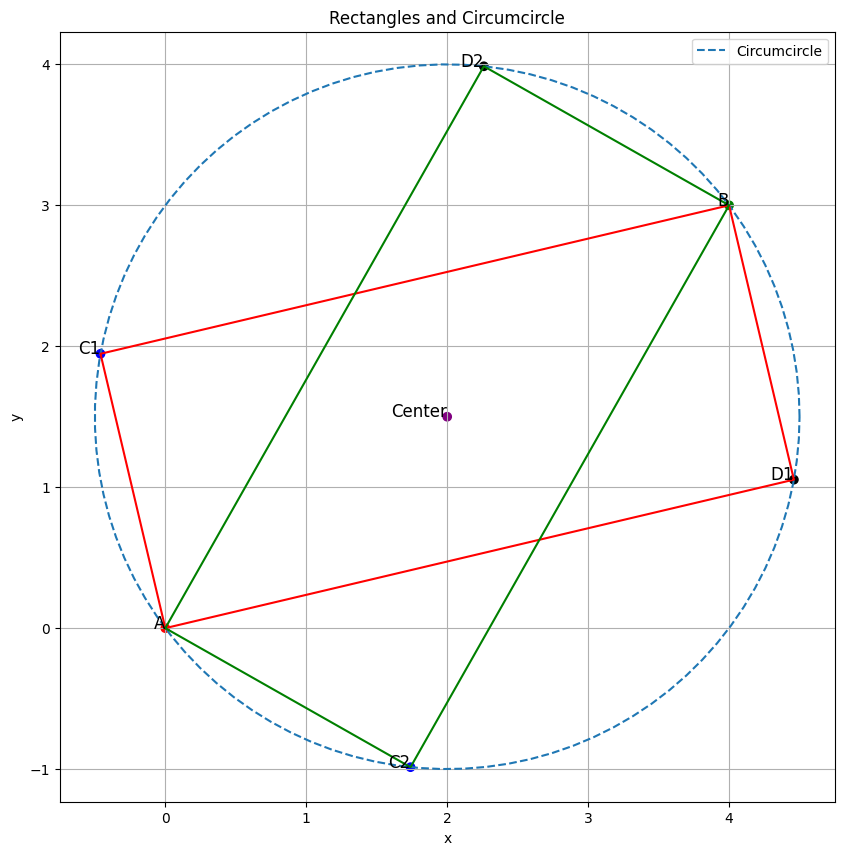

In [2]:
print (A , B , C1 , C2 , D1 , D2)
center = (x_center, y_center)

# Data for the circumcircle
theta = np.linspace(0, 2*np.pi, 100)
x_circle = center[0] + r * np.cos(theta)
y_circle = center[1] + r * np.sin(theta)


# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_circle, y_circle, linestyle='--', label='Circumcircle')
plt.scatter(*zip(*[A, B, C1, C2, center,D1,D2]), c=['red', 'green', 'blue', 'blue', 'purple','black','black'])


# Label points
plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C1[0], C1[1], 'C1', fontsize=12, ha='right')
plt.text(C2[0], C2[1], 'C2', fontsize=12, ha='right')
plt.text(D1[0], D1[1], 'D1', fontsize=12, ha='right')
plt.text(D2[0], D2[1], 'D2', fontsize=12, ha='right')
plt.text(center[0], center[1], 'Center', fontsize=12, ha='right')

# Draw rectangles
rectangle1 = np.array([A, C1, B, D1, A])
rectangle2 = np.array([A, C2, B, D2, A])
plt.plot(rectangle1[:,0], rectangle1[:,1], 'r-')
plt.plot(rectangle2[:,0], rectangle2[:,1], 'g-')

plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rectangles and Circumcircle')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
# Unpack points for scatter plot
x_coords = [A[0], B[0], C1[0], C2[0], center[0], D1_options[0], D2_options[0]]
y_coords = [A[1], B[1], C1[1], C2[1], center[1], D1_options[1], D2_options[1]]

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_circle, y_circle, linestyle='--', label='Circumcircle')
plt.scatter(x_coords, y_coords, c=['red', 'green', 'blue', 'blue', 'purple', 'black', 'black'])

# Label points and other plot elements
# ... (This part remains unchanged in your code)

plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rectangles and Circumcircle')
plt.grid(True)
plt.legend()
plt.show()

KeyError: 0